In [225]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import yfinance as yf
%matplotlib inline

In [226]:
def get_current_price(dtime):
    """종목의 현재가를 반환한다."""
    str_dtime = dtime.strftime('%Y-%m-%d %H:%M') # datetime -> str
    df = pd.read_csv('./YfinanceData/TQQQ/tqqq.csv', index_col=0, parse_dates=True) # 1minute data
    return df.loc[str_dtime].iloc[0]['Close'] # 종가 반환

In [227]:
def get_target_price(date):
    """매수 목표가를 반환한다. 매수 목표가 = 금일 시작 가격 + (어제 최고가 - 어제 최저가) * k"""
    df = pd.read_csv('./YfinanceData/1d/tqqq.csv', index_col=0, parse_dates=True) #1day data
    str_today = date.strftime('%Y-%m-%d')
    today = df.loc[str_today]
    lastday1 = (date - timedelta(days=1)).strftime('%Y-%m-%d')
    lastday5 = (date - timedelta(days=5)).strftime('%Y-%m-%d')
    lastday = df.query(f'"{lastday5}" <= Date <= "{lastday1}"').iloc[-1]

    target = today['Open'] + (lastday['High'] - lastday['Low']) * 0.4
    return target

In [228]:
class VBOStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.qty = 0
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=5)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' % (order.executed.price,
                                                                               order.executed.value,
                                                                               order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price : %.2f, Cose: %.2f, Comm, %.2f' % (order.executed.price,
                                                                                  order.executed.value,
                                                                                  order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/ Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):

        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        #시간이 안 맞는다.
        cur_date = self.data.datetime.date() 
        cur_time = self.data.datetime.time()
        cur_dtime = self.data.datetime.datetime() - timedelta(hours=4)
        
        t_start = cur_dtime.replace(hour=9, minute=30, second=0, microsecond=0)
        t_sell = cur_dtime.replace(hour=15, minute=58, second=0, microsecond=0)
        t_exit = cur_dtime.replace(hour=16, minute=00, second=0, microsecond=0)
        
        
        if t_start < cur_dtime < t_exit :
            target_price = get_target_price(cur_date)
            cur_price = get_current_price(cur_dtime)

            if self.order:
                if self.buyprice > 
                return

            if not self.position:
                if t_start < cur_dtime < t_sell :
                    if cur_price > target_price and cur_price > self.sma[0]:  
                        available_qty = self.broker.getcash() // cur_price
                        self.qty += available_qty
                        self.log('BUY CREATE, %.2f'%self.dataclose[0])
                        self.order = self.buy(size=available_qty)
                        print(self.qty)
            else :
                if t_sell < cur_dtime < t_exit:
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell(size= self.qty)
                    self.qty = 0
        else : 
            return

Starting Portfolio Value: 1000000.00
2022-08-03, BUY CREATE, 34.50
28982.0
2022-08-03, BUY EXECUTED, Price: 34.50, Cost: 999879.00, Comm 0.00
2022-08-03, SELL CREATE, 35.76
2022-08-03, SELL EXECUTED, Price : 35.76, Cose: 999879.00, Comm, 0.00
2022-08-03, OPERATION PROFIT, GROSS 36517.27, NET 36517.27
Final Portfolio Value : 1036517.27


<IPython.core.display.Javascript object>


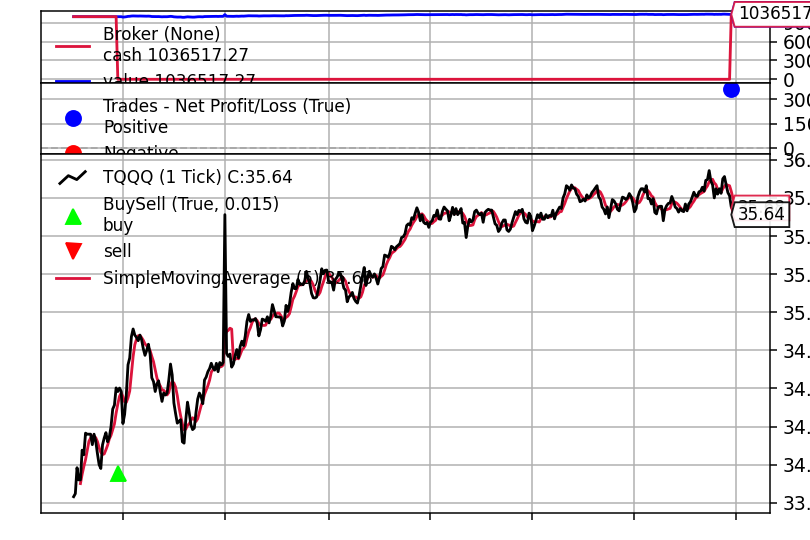

In [230]:
if __name__ == '__main__':
    # 1minute data
    df = pd.read_csv('./YfinanceData/TQQQ/tqqq.csv', index_col= 0, parse_dates=True)
    ticker = 'TQQQ'
    data = bt.feeds.PandasData(dataname=df, timeframe=1, fromdate = datetime(2022, 8, 3),
                               todate = datetime(2022, 8, 4))

    cerebro = bt.Cerebro()
    cerebro.addstrategy(VBOStrategy)
    cerebro.broker.setcommission(commission=0)
    cerebro.adddata(data, name=ticker)
    cerebro.broker.setcash(1000000.0)

    print('Starting Portfolio Value: %.2f' % (cerebro.broker.getvalue()))
    cerebro.run()
    print('Final Portfolio Value : %.2f' % (cerebro.broker.getvalue()))
    cerebro.plot(volume=False, savefig=True, path='./backtrader-plot2.png')